<a href="https://colab.research.google.com/github/araghavendra16/pytorchcv/blob/main/pytorch_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Import the packages needed.
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

PyTorch has a number of datasets available right from the library. Here we are using the well-known MNIST dataset of handwritten digits, available through torchvison.datasets.MNIST in PyTorch. The dataset object returns the data in the form of Python Imagine Library (PIL) images, which we convert to tensors by passing a transform=ToTensor() parameter.

When using your own notebooks, you can also experiment with the other built in datasets, in particular FashionMNIST.

In [3]:
from torchvision.transforms import ToTensor

data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
from google.colab import output
output.enable_custom_widget_manager()

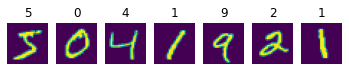

In [5]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(data_train[i][0].view(28,28))
    ax[i].set_title(data_train[i][1])
    ax[i].axis('off')

We have a total of 6000 training images and 1000 testing images. Its important to split out the data for training and testing. We also want to do some data exploration to get a better idea of what our data looks like

Each sample is a tuple in the following structure:

First element is the actual image of a digit, represented by a tensor of shape 1x28x28

Second element is a label that specifies which digit is represented by the tensor. It is a tensor that contains a number from 0 to 9.
data_train is a training dataset that we will use to train our model on. data_test is a smaller test dataset that we can use to verify our model.

In [6]:
print('Training samples:',len(data_train))
print('Test samples:',len(data_test))

print('Tensor size:',data_train[0][0].size())
print('First 10 digits are:', [data_train[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [7]:
print('Min intensity value: ',data_train[0][0].min().item())
print('Max intensity value: ',data_train[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


Let's focus on the problem of handwritten digit recognition. It is a classification problem, because for each input image we need to specify the class - which digit it is.

In this unit, we start with the simplest possible approach for image classification - a fully-connected neural network (which is also called a perceptron). We will recap the way neural networks are defined in PyTorch, and how the training algorithm works. 

In [8]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
#pip install pytorchcv
!pip install torchinfo
from google.colab import output
output.enable_custom_widget_manager()

--2022-08-21 16:32:59--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.22K  --.-KB/s    in 0s      

2022-08-21 16:32:59 (63.8 MB/s) - ‘pytorchcv.py’ saved [6371/6371]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary

from pytorchcv import load_mnist, plot_results
load_mnist()

In [10]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

In [11]:
print('Digit to be predicted: ',data_train[0][1])
torch.exp(net(data_train[0][0]))  # Because we use LogSoftmax as final activation of our network, we pass network output through torch.exp to get probabilities.

Digit to be predicted:  5


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.0953, 0.0915, 0.0911, 0.1191, 0.0985, 0.0885, 0.0862, 0.0912, 0.1266,
         0.1121]], grad_fn=<ExpBackward0>)

To train the model we will need to create batches from our dataset of a certain size, let's say 64. PyTorch has an object called DataLoader that can create batches of our data for us automatically:

In [12]:
train_loader = torch.utils.data.DataLoader(data_train,batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=64) # we can use larger batch size for testing

The training process steps are as follows:

1. We take a minibatch from the input dataset, which consists of input data (features) and expected result (label).

2. We calculate the predicted result for this minibatch.

3. The difference between this result and expected result is calculated using a special function called the loss function. Loss function shows how different the output of the network is from the expected output. The goal of our training is to minimize the loss.

4. We calculate the gradients of this loss function with respect to model weights (parameters), which are then used to adjust the weights to optimize the performance of the network. The amount of adjustment is controlled by a parameter called learning rate, and the details of optimization algorithm are defined in the optimizer object.
5. We repeat those steps until the whole dataset is processed. One complete pass through the dataset is called an epoch.

Here is a function that performs one epoch training:

In [13]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)

(0.005928902180989583, 0.8927333333333334)

Since this function is pretty generic we will be able to use it later in our other examples. The function takes the following parameters:
* **Neural network**
* **DataLoader**, which defines the data to train on
* **Loss Function**, which is a function that measures the difference between the expected result and the one produced by the network. In most of the classification tasks `NLLLoss` is used, so we will make it a default.
* **Optimizer**, which defined an *optimization algorithm*. The most traditional algorithm is *stochastic gradient descent*, but we will use a more advanced version called **Adam** by default.
* **Learning rate** defines the speed at which the network learns. During learning, we show the same data multiple times, and each time weights are adjusted. If the learning rate is too high, new values will overwrite the knowledge from the old ones, and the network would perform badly. If the learning rate is too small it results in a very slow learning process. 

Here is what we do when training:
* Switch the network to training mode (`net.train()`)
* Go over all batches in the dataset, and for each batch do the following:
   - compute predictions made by the network on this batch (`out`)
   - compute `loss`, which is the discrepancy between predicted and expected values
   - try to minimize the loss by adjusting weights of the network (`optimizer.step()`)
   - compute the number of correctly predicted cases (**accuracy**)

The function calculates and returns the average loss per data item, and training accuracy (percentage of cases guessed correctly). By observing this loss during training we can see whether the network is improving and learning from the data provided.

It is also important to control the accuracy on the test dataset (also called **validation accuracy**). A good neural network with a lot of parameters can predict with decent accuracy on any training dataset, but it may poorly generalize to other data. That's why in most cases we set aside part of our data, and then periodically check how well the model performs on them. Here is the function to evaluate the network on test dataset:


In [14]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.005852312088012695, 0.8939)

In [15]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.893, Val acc=0.894, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.917, Val acc=0.897, Train loss=0.005, Val loss=0.006


This function logs messages with the accuracy on training and validation data from each epoch. It also returns this data as a dictionary (called history). We can then visualize this data to better understand our model training.

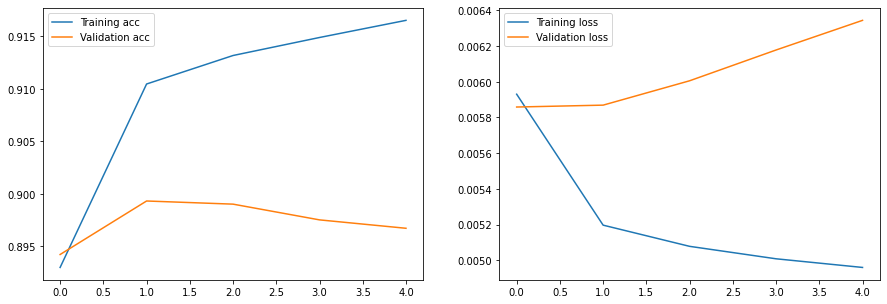

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()


The diagram on the left shows the training accuracy increasing (which corresponds to the network learning to classify our training data better and better), while validation accuracy starts to fall. The diagram on the right show the training loss and validation loss, you can see the training loss decreasing (meaning its performing better) and the validation loss increasing (meaning its performing worse). These graphs would indicate the model is overfitted.

In the code below, we will first get the matrix  
W
  into weight_tensor variable. It can be obtained by calling the net.parameters() method (which returns both  
W
  and  
b
 ), and then calling next to get the first of two parameters. Then we will go over each dimension, reshape it to  
28
×
28
  size, and plot. You can see that 10 weight tensor dimensions somewhat resemble the average shape of the digits they classify:
  

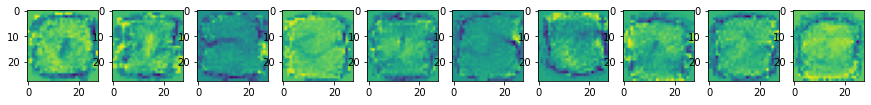

In [17]:
weight_tensor = next(net.parameters())
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())

### Multi-layered perceptron

To further increase accuracy, we may want to include one or more **hidden layers**.

<img alt="An image showing a multi-layer network with a hidden layer between the input layer and the output layer" src="images/3-train-dense-neural-networks-4.png" width="70%"/>

Our network layer structure will look like this:

<img alt="An image showing the network layer structure as it's broken down into layers" src="images/3-train-dense-neural-networks-5.png" width="70%"/>

An important thing to note here is the non-linear activation function between layers, called **ReLU**. It is important to introduce those non-linear activation functions, because they are one of the reasons neural networks achieve high expressive power. Indeed, it can be demonstrated mathematically that if a network consisted just of a series of linear layers, it would essentially be equivalent to one linear layer. Thus inserting non-linear functions in between layers is important!

**ReLU** is a simplest activation function, which is defined as follows:

$$
\mathrm{ReLU}(x) = \begin{cases} 0 & x<0 \\ x & x\ge0 \end{cases}
$$

Other activation functions used in deep learning are sigmoid and tanh, but ReLU is most often used in computer vision, because it can be quickly computed, and using other functions does not bring any significant benefits.



In [18]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax(dim=0))

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

In [19]:
from torch.nn.functional import relu, log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x,dim=0)
        return x

net = MyNet()

summary(net,input_size=(1,28,28),device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

You can see that the structure of a neural network is the same as with the `Sequential`-defined network, but the definition is more explicit. Our custom neural network is represented by a class inherited from ``torch.nn.Module`` class.

Class definition consists of two parts:
* In the constructor (`__init__`) we define all layers that our network will have. Those layers are stored as internal variables of the class, and PyTorch will automatically know that parameters of those layers should be optimized when training. Internally, PyTorch uses `parameters()` method to look for all trainable parameters, and `nn.Module` will automatically collect all trainable parameters from all sub-modules. 
* We define the `forward` method that does the forward pass computation of our neural network. In our case, we start with a parameter tensor `x`, and explicitly pass it through all the layers and activation functions, starting from `flatten`, up to final linear layer `out`. When we apply our neural network to some input data `x` by writing `out = net(x)`, the `forward` method is called. 

In fact, `Sequential` networks are represented in a very similar manner, they just store a list of layers and apply them sequentially during the forward pass. Here we have a chance to represent this process more explicitly, which eventually gives us more flexibility. That is one of the reasons that using classes for neural network definition is a recommended and preferred practice.

You can now try to train this network using exactly the same `train` function that we've defined above:

Epoch  0, Train acc=0.928, Val acc=0.945, Train loss=0.035, Val loss=0.034
Epoch  1, Train acc=0.951, Val acc=0.953, Train loss=0.033, Val loss=0.033
Epoch  2, Train acc=0.958, Val acc=0.955, Train loss=0.033, Val loss=0.033
Epoch  3, Train acc=0.960, Val acc=0.950, Train loss=0.033, Val loss=0.034
Epoch  4, Train acc=0.960, Val acc=0.955, Train loss=0.033, Val loss=0.033


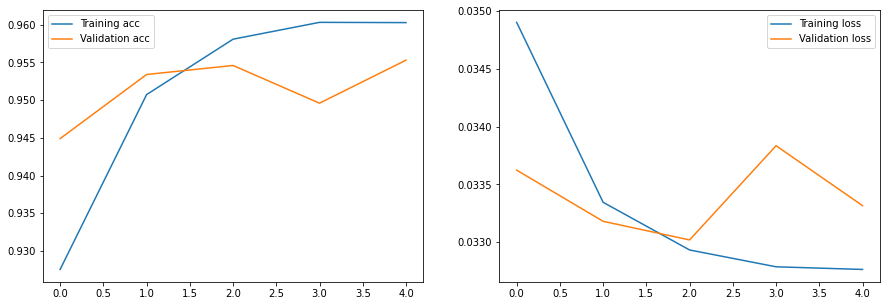

In [20]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

## Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.

<img alt="Sliging window over 28x28 digit image" src="images/4-convolutional-networks-1.png" width="50%"/>

They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:

In [21]:
from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

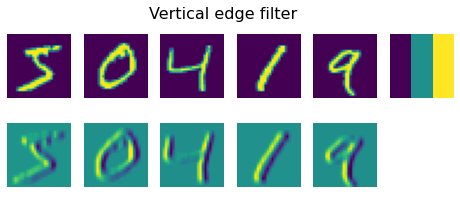

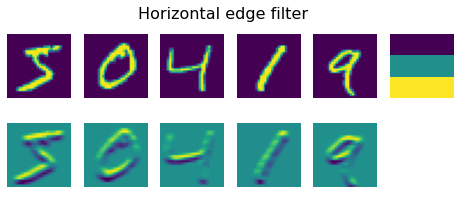

In [22]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')


In [23]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()

summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalize much better.

> Note that the number of parameters of convolutional layer is quite small, and it *does not depend on the resolution of the image*! In our case, we were using 9 filters of dimension $5\times5$, thus the number of parameters is $9\times5\times5+9=234$. Even though we missed this in our discussion above, but convolutional filter also has bias. Most of the parameters of our network comes from the final `Dense` layer.

Epoch  0, Train acc=0.953, Val acc=0.953, Train loss=0.002, Val loss=0.003
Epoch  1, Train acc=0.977, Val acc=0.959, Train loss=0.001, Val loss=0.002
Epoch  2, Train acc=0.982, Val acc=0.969, Train loss=0.001, Val loss=0.002
Epoch  3, Train acc=0.985, Val acc=0.977, Train loss=0.001, Val loss=0.002
Epoch  4, Train acc=0.988, Val acc=0.977, Train loss=0.001, Val loss=0.002


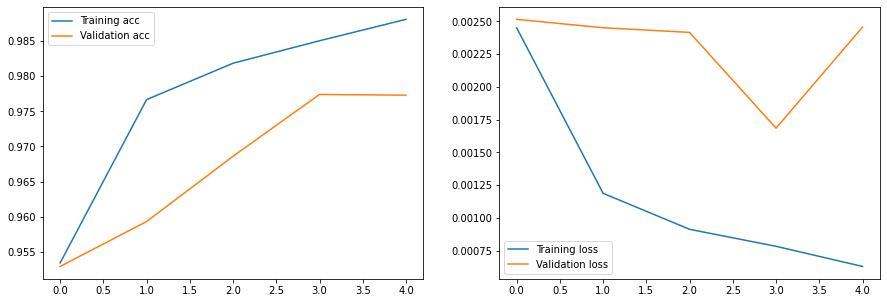

In [24]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

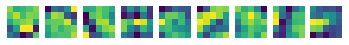

In [25]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

You can see that some of those filters look like they can recognize some oblique strokes, while others look pretty random. 

## Takeaway

Convolutional layer allows us to extract certain image patterns from the image, so that final classifier is based on top of those features. However, we can use the same approach of extracting patterns inside the feature space, by stacking another convolutional layer on top of the first one. We will learn about multi-layer convolutional networks in the next unit.

In [26]:
# A convolutional layer contains less parameters : a  convolutional layer contains small filters that have the same weights for the whole image


In [27]:
# Multi-layer CNN 
from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

## Pooling layers

First convolutional layers looks for primitive patterns, such as horizontal or vertical lines. Next level of convolutional layers on top of them look for higher-level patterns, such as primitive shapes. More convolutional layers can combine those shapes into some parts of the picture, up to the final object that we are trying to classify. This creates a hierarchy of extracted patterns.

When doing so, we also need to apply one trick: reducing the spatial size of the image. Once we have detected there is a horizontal stoke within a sliding window, it is not so important at which exact pixel it occurred. Thus we can "scale down" the size of the image, which is done using one of the **pooling layers**:

 * **Average Pooling** takes a sliding window (for example, 2x2 pixels) and computes an average of values within the window
 * **Max Pooling** replaces the window with the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window.

<img alt="Max Pooling" src="images/5-multilayer-convolutions-1.png" width="50%"/>

Thus, in a typical CNN there would be composed of several convolutional layers, with pooling layers in between them to decrease dimensions of the image. We would also increase the number of filters, because as patterns become more advanced - there are more possible interesting combinations that we need to be looking for.

![An image showing several convolutional layers with pooling layers.](images/5-multilayer-convolutions-2.png)

Because of decreasing spatial dimensions and increasing feature/filters dimensions, this architecture is also called **pyramid architecture**. 

In the next example, we will use two-layered CNN:

In [28]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

Note a few things about the definition:
* Instead of using `Flatten` layer, we are flattening the tensor inside `forward` function using `view` function, which is similar to `reshape` function in numpy. Since flattening layer does not have trainable weights, it is not required that we create a separate layer instance within our class - we can just use a function from `torch.nn.functional` namespace.
* We use just one instance of pooling layer in our model, also because it does not contain any trainable parameters, and thus one instance can be effectively reused.
* The number of trainable parameters (~8.5K) is dramatically smaller than in previous cases (80K in Perceptron, 50K in one-layer CNN). This happens because convolutional layers in general have few parameters, independent of the input image size. Also, due to pooling, dimensionality of the image is significantly reduced before applying final dense layer. Small number of parameters have positive impact on our models, because it helps to prevent overfitting even on smaller dataset sizes.

In [29]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.954, Val acc=0.969, Train loss=0.002, Val loss=0.002
Epoch  1, Train acc=0.979, Val acc=0.980, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.982, Val acc=0.984, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.983, Val acc=0.982, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.983, Val acc=0.978, Train loss=0.001, Val loss=0.001


What you should probably observe is that we are able to achieve higher accuracy, and much faster - just with 1 or 2 epochs. It means that sophisticated network architecture needs much fewer data to figure out what is going on, and to extract generic patterns from our images.

In [30]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


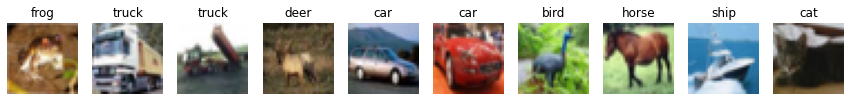

In [31]:
display_dataset(trainset,classes=classes)

A well-known architecture for CIFAR-10 is called [LeNet](https://en.wikipedia.org/wiki/LeNet), and has been proposed by *Yann LeCun*. It follows the same principles as we have outlined above. However, since all images are color, input tensor size is $3\times32\times32$, and the $5\times5$ convolutional filter is applied across color dimension as well - meaning that the size of convolution kernel matrix is $3\times5\times5$. 

We also do one more simplification to this model - we do not use `log_softmax` as output activation function, and just return the output of last fully-connected layer. In this case we can just use `CrossEntropyLoss` loss function to optimize the model.

In [32]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [33]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.247, Val acc=0.377, Train loss=0.145, Val loss=0.120
Epoch  1, Train acc=0.443, Val acc=0.475, Train loss=0.109, Val loss=0.102
Epoch  2, Train acc=0.509, Val acc=0.523, Train loss=0.097, Val loss=0.094
